<a href="https://colab.research.google.com/github/fahm8/Analisis-Turf_M.Fahmi/blob/main/M_Fahmi_TURF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install Library
!pip install pingouin

In [ ]:
#Import Library
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pingouin as pg
from scipy.spatial.distance import mahalanobis
from numpy.linalg import inv
from scipy.stats import chi2
from sklearn.covariance import MinCovDet

**Latar Belakang**

Sebuah perusahaan food delivery app ingin mengembangkan 3 fitur baru dari 8 opsi yang ada. Survei dilakukan pada 550 responden untuk mengetahui preferensi mereka terhadap fitur-fitur berikut:

- Diskon - Promo harga atau paket hemat

- E-Wallet - Pembayaran via GoPay/OVO/DANA

- Tracking Kurir - Lacak lokasi kurir real-time

- Makanan Sehat - Menu rendah kalori/organik

- Loyalty Points - Program poin/member eksklusif

- UI Nyaman - Tampilan aplikasi yang intuitif

- Pengiriman Cepat - Layanan express (<30 menit)

- Rating & Review - Ulasan dan penilaian pengguna

Setiap responden memberikan jawaban biner (1 = Suka, 0 = Tidak Suka).

Data dikelompokkan berdasarkan kategori usia (16-20, 21-25, 26-30, 31-35 tahun), menggunakan algoritma TURF untuk menghitung reach kumulatif tiap kombinasi fitur, Menemukan kombinasi fitur minimal (bisa 2, 3, atau lebih) untuk
mencapai target reach yang ditentukan dan overlap terendah.

In [ ]:
#Data
url = "https://raw.githubusercontent.com/fahm8/Analisis-Turf_M.Fahmi/main/food_app_preferences.csv"
df = pd.read_csv(url)
df.head()

,ID,Diskon,Ewallet,Tracking,Healthy,Loyalty,UI,Cepat,Rating,Umur
0,1,0,1,0,0,0,1,0,0,46
1,2,0,1,0,0,0,0,1,0,30
2,3,1,1,1,0,1,0,1,1,36
3,4,1,1,1,1,1,1,0,0,41
4,5,1,1,1,0,1,0,0,0,40



=== TURF Analysis untuk Usia 16-20 ===


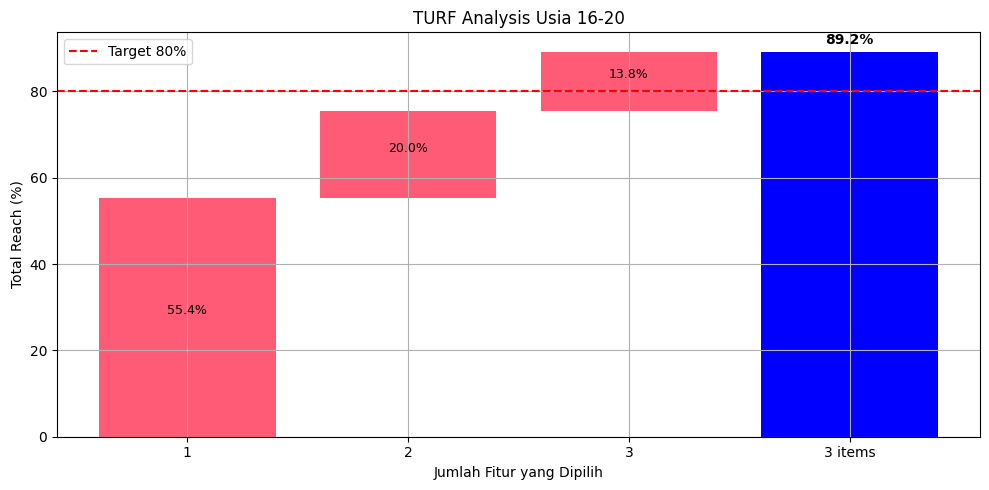

✔ Untuk mencapai minimal 80% pada usia 16-20, perlu 3 fitur.
📌 Fitur yang optimal: ['Ewallet', 'Tracking', 'Rating']

=== TURF Analysis untuk Usia 21-25 ===


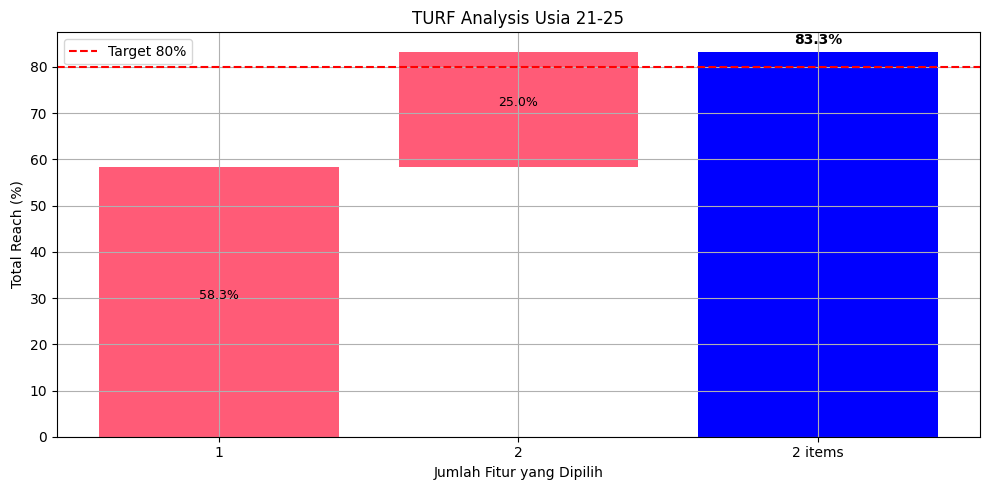

✔ Untuk mencapai minimal 80% pada usia 21-25, perlu 2 fitur.
📌 Fitur yang optimal: ['Cepat', 'Healthy']

=== TURF Analysis untuk Usia 26-30 ===


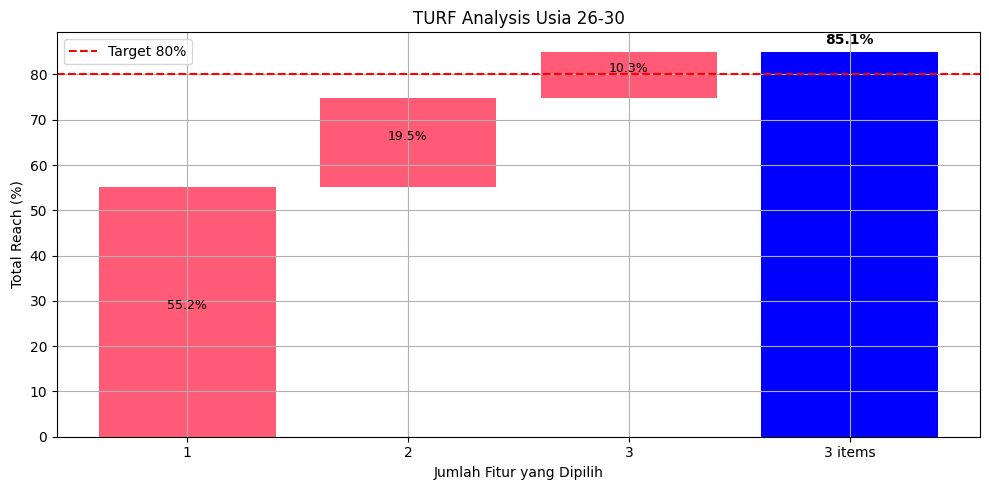

✔ Untuk mencapai minimal 80% pada usia 26-30, perlu 3 fitur.
📌 Fitur yang optimal: ['Diskon', 'UI', 'Tracking']

=== TURF Analysis untuk Usia 31-35 ===


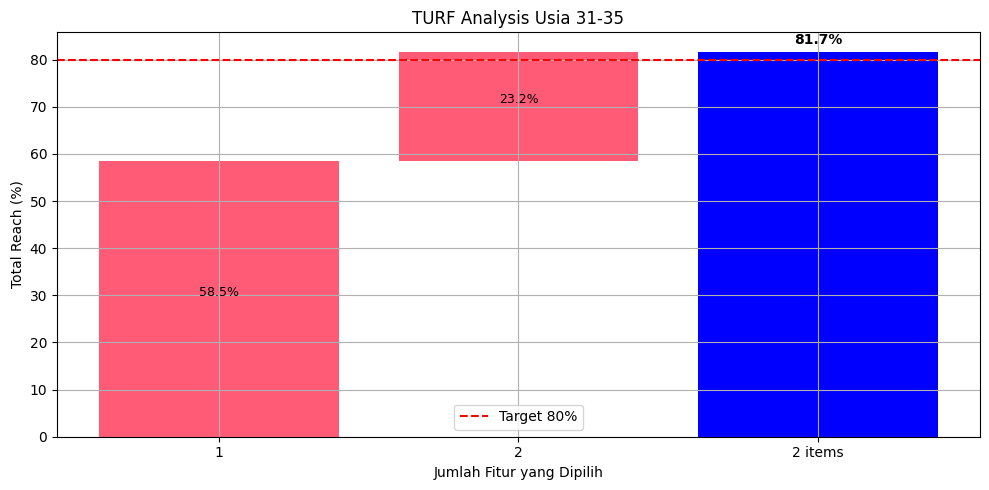

✔ Untuk mencapai minimal 80% pada usia 31-35, perlu 2 fitur.
📌 Fitur yang optimal: ['Cepat', 'Ewallet']


In [ ]:
# Pastikan kategori usia sudah terbentuk
df['kategori_usia'] = pd.cut(df['Umur'],
                             bins=[15, 20, 25, 30, 35],
                             labels=['16-20', '21-25', '26-30', '31-35'])

# Parameter
Target_dalam_persen = 80
target_reach_pct = Target_dalam_persen / 100

# Mulai loop per kategori usia
for kategori in sorted(df['kategori_usia'].dropna().unique()):
    data_kat = df[df['kategori_usia'] == kategori]

    if len(data_kat) == 0:
        print(f"\nTidak ada data untuk usia {kategori}")
        continue

    print(f"\n=== TURF Analysis untuk Usia {kategori} ===")
    target_reach = int(target_reach_pct * len(data_kat))

    index_ = data_kat.columns.get_loc("Diskon")  # asumsi 'Diskon' adalah fitur pertama
    relevant_cols = data_kat.columns[index_:].difference(['kategori_usia', 'Umur'])  # Exclude age columns

    reach_per_item = data_kat[relevant_cols].sum(axis=0).sort_values(ascending=False)

    selected_items = []
    current_reach = set()
    reach_progress = []

    for item in reach_per_item.index:
        new_reach = current_reach | set(data_kat.index[data_kat[item] == 1])
        selected_items.append(item)
        reach_progress.append(len(new_reach) / len(data_kat))
        if len(new_reach) >= target_reach:
            break
        current_reach = new_reach

    incrementals = [reach_progress[0]] + [reach_progress[i] - reach_progress[i - 1] for i in range(1, len(reach_progress))]

    # Visualisasi
    plt.figure(figsize=(10, 5))
    bottoms = 0
    for i, inc in enumerate(incrementals):
        plt.bar(f"{i + 1}", inc * 100, bottom=bottoms, color="#ff5b77")
        plt.text(i, bottoms + inc * 50, f"{inc * 100:.1f}%", ha='center', va='bottom', fontsize=9)
        bottoms += inc * 100

    plt.axhline(y=target_reach_pct * 100, color='r', linestyle='--', label=f'Target {Target_dalam_persen}%')
    plt.bar(f"{len(selected_items)} items", reach_progress[-1] * 100, color="blue")
    plt.text(len(selected_items), reach_progress[-1] * 100 + 1, f"{reach_progress[-1] * 100:.1f}%",
             ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.xlabel("Jumlah Fitur yang Dipilih")
    plt.ylabel("Total Reach (%)")
    plt.title(f"TURF Analysis Usia {kategori}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Output teks
    if reach_progress[-1] >= target_reach_pct:
        print(f"✔ Untuk mencapai minimal {Target_dalam_persen}% pada usia {kategori}, perlu {len(selected_items)} fitur.")
    else:
        print(f"✖ Tidak dapat mencapai {Target_dalam_persen}%. Maksimal hanya {reach_progress[-1] * 100:.1f}%")

    print("📌 Fitur yang optimal:", selected_items)


**Kesimpulan**

Dari analisis diatas, didapat kesimpulan sebagai berikut:
1. Usia 16-20 Tahun

Kombinasi fitur aplikasi yang menjangkau paling tidak 80% pengguna unik di kelompok ini yaitu, fitur Ewallet, Tracking, dan Rating.
2. Usia 21-25 Tahun

Kombinasi fitur aplikasi yang menjangkau paling tidak 80% pengguna unik di kelompok ini yaitu, fitur Cepat dan Healthy

3. Usia 26-30 Tahun

Kombinasi fitur aplikasi yang menjangkau paling tidak 80% pengguna unik di kelompok ini yaitu, fitur Diskon, UI, dan Tracking
4. Usia 31-35 Tahun

Kombinasi fitur aplikasi yang menjangkau paling tidak 80% pengguna unik di kelompok ini yaitu, fitur Cepat dan Ewallet